In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from data_utils import *
from eda_utils import *
from train_utils import *
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import wandb
from keys import WANDB_KEY
from sklearn.preprocessing import StandardScaler

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
phyt_cod_path = 'data/PHYT_COD_ForDvirLafer.csv'
phyto_path = 'data/Phyto4DvirLafer.csv'

biomass_by_week_year_group = get_biomass_data(phyt_cod_path, phyto_path)

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [4]:
fp_path = 'data/FP_2017_ForDvirLafer.csv'

fp_df = get_fluorprobe_data(fp_path)

Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.


In [5]:
fp_df['depth_discrete'] = fp_df['depth'].apply(lambda x: min(biomass_by_week_year_group['Depth'], key=lambda y: abs(y - x)))

In [6]:
fp_df.rename(columns={'depth_discrete': 'Depth'}, inplace=True)
fp_df.drop('depth', axis=1, inplace=True)
fp_df.drop_duplicates(inplace=True)

merged_df = fp_df.merge(biomass_by_week_year_group, on=['week', 'year', 'month', 'Depth'])

In [18]:
class BiomassDataset(Dataset):
    def __init__(self, biomass_df, merged_df, scaler=None, is_train=True):
        features = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sensor', 'Total conc', 'month', 'week', 'year', 'Depth']
        cols_to_scale = ['red', 'green', 'yellow', 'orange', 'violet', 'brown', 'blue', 'pressure', 'temp_sensor', 'Total conc']
        if is_train:
            temp_biomass_df = biomass_df[((biomass_df['year'] == 2022) & (biomass_df['month'] < 4)) | (biomass_df['year'] < 2022)].copy()    
            temp_merged_df = merged_df[((merged_df['year'] == 2022) & (merged_df['month'] < 4)) | (merged_df['year'] < 2022)].copy()
        else:
            temp_biomass_df = biomass_df[(biomass_df['year'] == 2022) & (biomass_df['month'] >= 4)].copy()    
            temp_merged_df = merged_df[(merged_df['year'] == 2022) & (merged_df['month'] >= 4)].copy()
        
        self.biomass_dict = self._get_biomass_dict(temp_biomass_df)  
        self.merged_df = temp_merged_df.drop_duplicates(features)[features]
        
        # Instantiate the StandardScaler
        if scaler is None:
            self.scaler = StandardScaler()
            self.scaler.fit(self.merged_df[cols_to_scale])
        else:
            self.scaler = scaler
        
        # Fit and transform the selected columns
        self.merged_df[cols_to_scale] = self.scaler.transform(self.merged_df[cols_to_scale])

    @staticmethod
    def _get_biomass_dict(df):
        d = {}
        for k, g in df.groupby(['week', 'year', 'month', 'Depth']):
            d[k] = []
            for group_num in [2, 3, 4, 5, 6, 7, 9]:
                biomass = 0
                if len(g[g.group_num == group_num]) > 0:
                    biomass = g[g.group_num == group_num]['sum_biomass_ug_ml'].iloc[0]
                d[k].append(biomass)
            d[k] = np.array(d[k])
        return d
    
    def __len__(self):
        return len(self.merged_df)

    def __getitem__(self, idx):
        k = tuple(self.merged_df.iloc[idx][['week', 'year', 'month', 'Depth']].to_list())
        input_values = self.merged_df.drop(['week', 'year', 'Depth'], axis=1).iloc[idx].values
        output_value = self.biomass_dict[k] * 100
        
        input_tensor = torch.tensor(input_values, dtype=torch.float32)
        output_tensor = torch.tensor(output_value, dtype=torch.float32)

        return input_tensor, output_tensor

In [19]:
batch_size = 8

train_ds = BiomassDataset(biomass_by_week_year_group, merged_df)
test_ds = BiomassDataset(biomass_by_week_year_group, merged_df, scaler=train_ds.scaler, is_train=False)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

In [20]:
train_ds[0][0]

tensor([ 6.1745e-01, -2.7410e-02,  8.6758e-04,  5.1505e-02,  7.0841e-02,
         9.6262e-02, -1.1830e-02, -1.4528e+00, -1.2732e+00,  2.0037e-01,
         1.2000e+01])

In [25]:
# Set hyperparameters
input_size = train_ds[0][0].shape[0]
hidden_size = 32
learning_rate = 1e-3
wd = 1e-6
output_size = train_ds[0][1].shape[0]
num_epochs = 100

wandb.login(key=WANDB_KEY, )

# Initialize wandb
wandb.init(project="kinnert-mlp-regressor", config={
    'input_size': input_size,
    'hidden_size': hidden_size,
    'lr': learning_rate,
    'weight_decay': wd,
    'output_size': output_size,
    'n_epochs': num_epochs
})

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Avg. Training Loss,█▅▂▁
Test Loss,▁▂▅█
Avg. Training Loss,3179.51284
Test Loss,3501.93086


In [26]:
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# # Normalize the input data
# scaler = StandardScaler()

# Define the MLP model
class MLPRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x)) # Forcing non-negativity
        x = self.fc3(x)
        return x

model = MLPRegressor(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_dl:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Log training loss to wandb
    wandb.log({"Avg. Training Loss": total_loss/len(train_dl)})
    
    # Evaluate on the test set
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_dl:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_dl)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Test Loss: {avg_loss:.4f}")
    
    # Log test loss to wandb
    wandb.log({"Test Loss": avg_loss})
    
    # Save model checkpoint
    checkpoint_path = f"checkpoints/checkpoint_epoch_{epoch+1}.pt"
    torch.save(model.state_dict(), checkpoint_path)

Epoch [1/100] - Test Loss: 1944.4351
Epoch [2/100] - Test Loss: 1305.8403
Epoch [3/100] - Test Loss: 1327.2426
Epoch [4/100] - Test Loss: 2046.4070
Epoch [5/100] - Test Loss: 2893.6891
Epoch [6/100] - Test Loss: 3072.8685
Epoch [7/100] - Test Loss: 2901.2634
Epoch [8/100] - Test Loss: 2680.8022
Epoch [9/100] - Test Loss: 2360.3860
Epoch [10/100] - Test Loss: 2224.5830
Epoch [11/100] - Test Loss: 1884.5681
Epoch [12/100] - Test Loss: 1758.2210
Epoch [13/100] - Test Loss: 1579.8629
Epoch [14/100] - Test Loss: 1339.7953
Epoch [15/100] - Test Loss: 1099.8384
Epoch [16/100] - Test Loss: 1202.7129
Epoch [17/100] - Test Loss: 1014.7177
Epoch [18/100] - Test Loss: 1016.8580
Epoch [19/100] - Test Loss: 894.3879
Epoch [20/100] - Test Loss: 920.6860
Epoch [21/100] - Test Loss: 841.8753
Epoch [22/100] - Test Loss: 864.1278
Epoch [23/100] - Test Loss: 889.6922
Epoch [24/100] - Test Loss: 1026.7628
Epoch [25/100] - Test Loss: 923.8813
Epoch [26/100] - Test Loss: 921.4580
Epoch [27/100] - Test Loss: 

KeyboardInterrupt: 

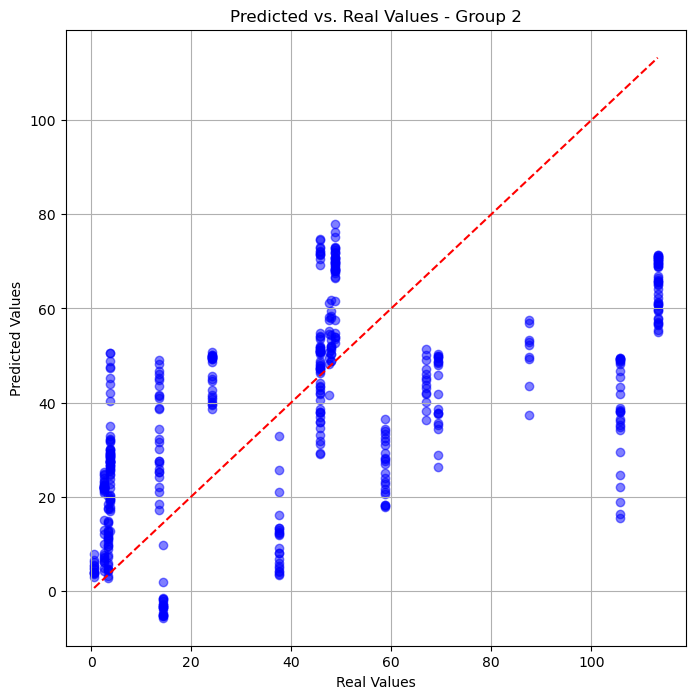

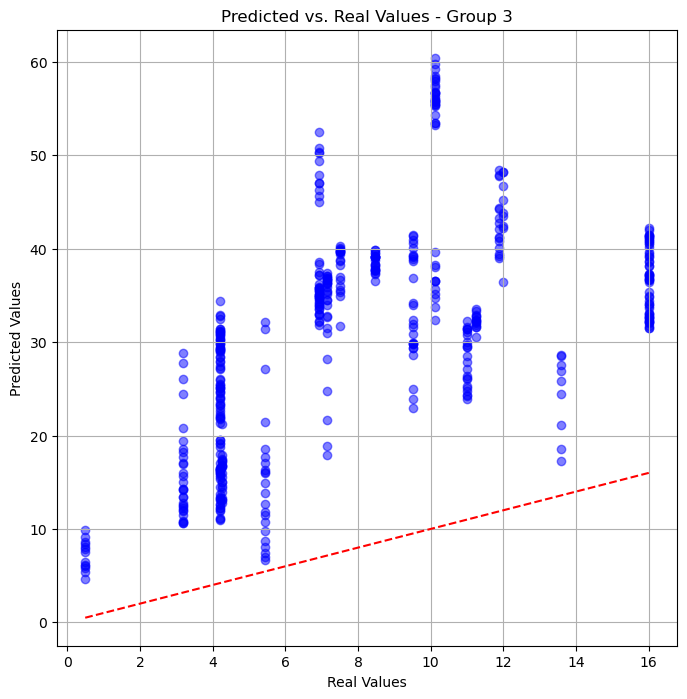

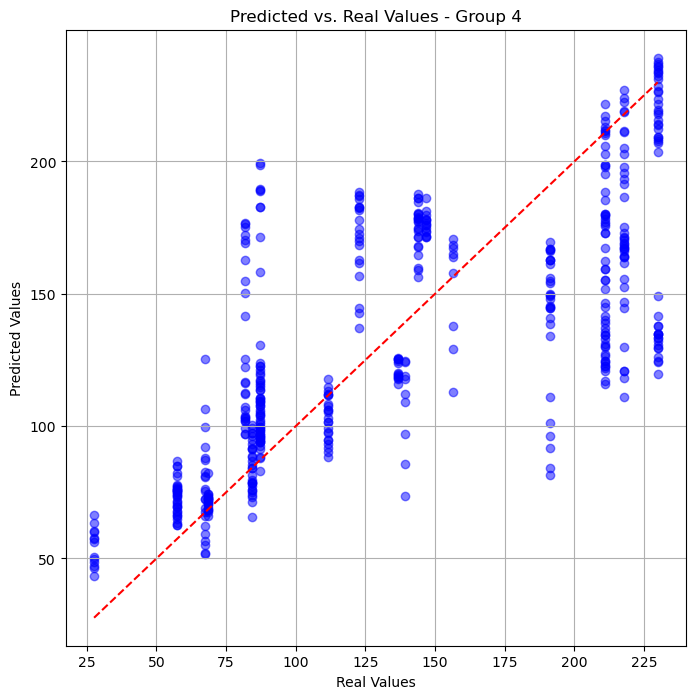

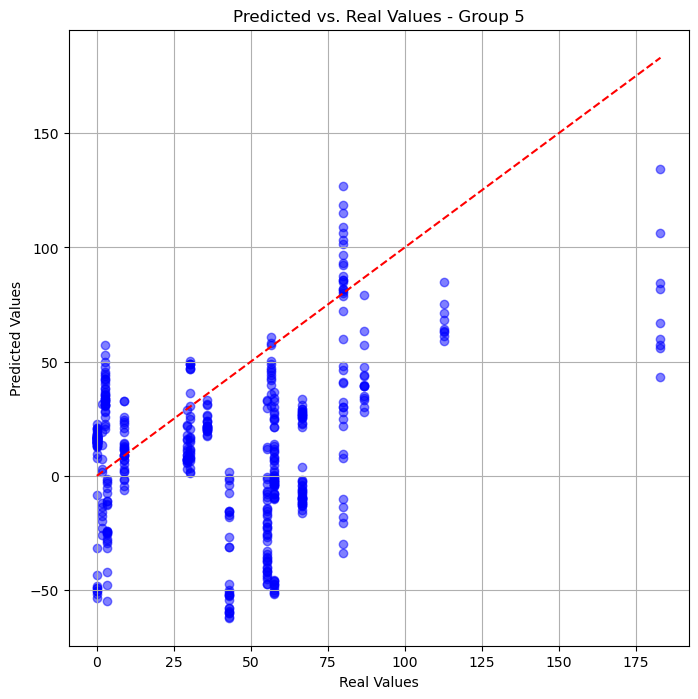

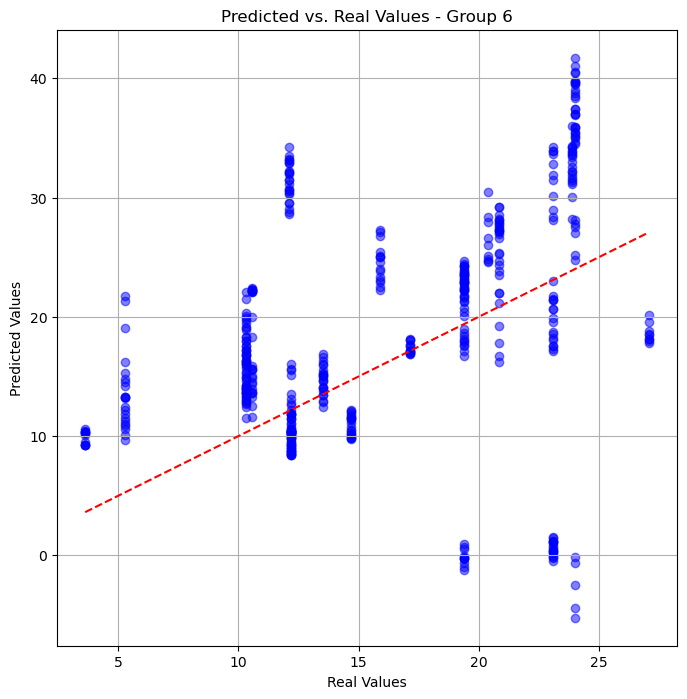

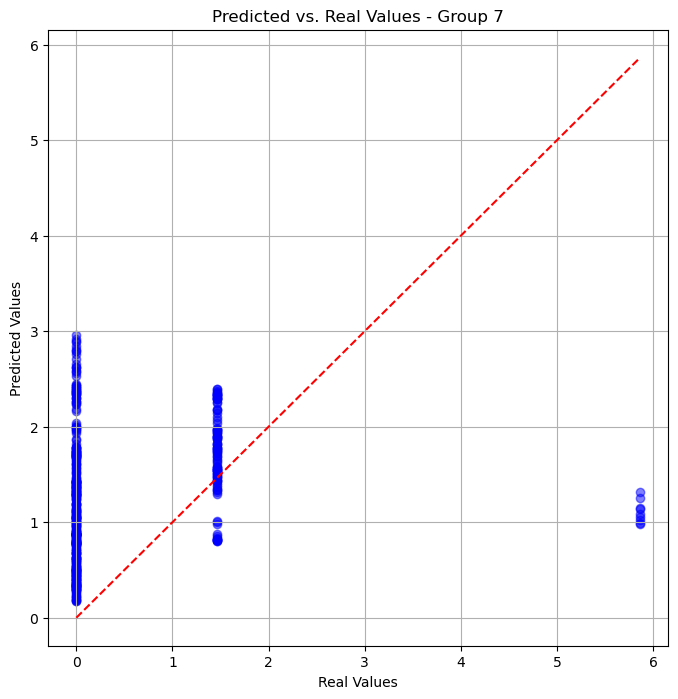

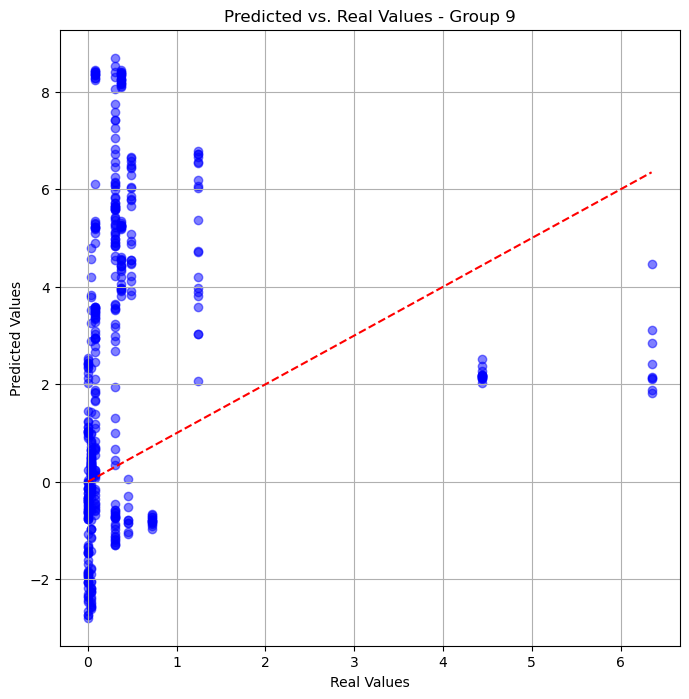

In [27]:
import matplotlib.pyplot as plt

epoch = 22
checkpoint_path = f"checkpoints/checkpoint_epoch_{epoch}.pt"  # Replace with the actual path
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint)

# Set the model to evaluation mode
model.eval()

# Lists to store real and predicted values
real_values = []
predicted_values = []

# Loop through the test data
with torch.no_grad():
    for inputs, targets in test_dl:
        outputs = model(inputs)
        real_values.extend(targets.numpy())
        predicted_values.extend(outputs.numpy())

# Convert lists to NumPy arrays for plotting
real_values = np.array(real_values)
predicted_values = np.array(predicted_values)

# Group indices for the separate plots
group_indices = [0, 1, 2, 3, 4, 5, 6]  # Update with your actual groups
group_mapping = {
    0: 2,
    1: 3,
    2: 4,
    3: 5,
    4: 6,
    5: 7,
    6: 9
}

# Create separate scatter plots for each group
for group_idx in group_indices:
    group_real = real_values[:, group_idx]
    group_predicted = predicted_values[:, group_idx]

    plt.figure(figsize=(8, 8))
    plt.scatter(group_real, group_predicted, color='blue', alpha=0.5)
    plt.plot([min(group_real), max(group_real)], [min(group_real), max(group_real)], color='red', linestyle='--')  # 45-degree line
    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs. Real Values - Group {group_mapping[group_idx]}')
    plt.grid(True)
    plt.show()
